<a href="https://colab.research.google.com/github/MauricioMatheus/Data-Structures-2_U2T1/blob/main/AED2_U2T1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.2 MB/s eta 0:00:00


In [1]:
!pip install codecarbon

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import folium
import codecarbon as cc
ox.settings.use_cache = True
ox.settings.log_console = True

##**Estruturação do Problema**

In [3]:
# Criação do grafo de Natal
G = ox.graph_from_place("Natal, Brazil", network_type = "drive")

# Estabelecimento da origem no grafo
orig_coords = (-5.807712684350378, -35.20352260316861) #Walfredo Gurgel
orig_node = ox.distance.nearest_nodes(G, X=orig_coords[1], Y=orig_coords[0]) #Encontrando o nó mais próximo ao hospital

# Estabelecimento dos bairros no grafo:
bairros = {
    "Alecrim" : (-5.798569959871097, -35.22008553155143),
    "Felipe Camarão" : (-5.824224067954413, -35.25358895396806),
    "Pajuçara" : (-5.734856488330359, -35.24077463730414)
}
dest_nodes = []
for nome_bairro, destino_coords in bairros.items():
  dest_nodes.append(ox.distance.nearest_nodes(G, X=destino_coords[1], Y=destino_coords[0]))


##**Algorítmo OSMnx**

In [4]:
paths_OSMnx = []

# Inicio da medição dos custos
tracker = cc.EmissionsTracker()
tracker.start()

#Algoritimo aplicado
for node in dest_nodes:
  route = ox.routing.shortest_path(G, orig_node, node, weight="lenght") #menor caminho
  paths_OSMnx.append(route)

emissions_OSMnx = tracker.stop()

[codecarbon WARNING @ 00:25:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:25:32] [setup] RAM Tracking...
[codecarbon INFO @ 00:25:32] [setup] CPU Tracking...
[codecarbon WARNING @ 00:25:33] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:25:33] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:25:33] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 00:25:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:25:33] [setup] GPU Tracking...
[codecarbon INFO @ 00:25:33] No GPU found.
[codecarbon INFO @ 00:25:33] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

#**Algorímos Dijsktra**

## Estruturação de dados em vertex, para o uso dos algoritimos Dijkstra

In [5]:
def get_adjacency_list(G):
    # Mapeamento de Nós para index de base 0
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    index_to_node = {idx: node for node, idx in node_to_index.items()}

    adj_list = [[] for _ in range(len(G.nodes()))]

    for u, v, data in G.edges(data=True):
        u_idx = node_to_index[u]  # Index do Nó de origem
        v_idx = node_to_index[v]  # Index Nó de destino

        # Adiciona a estrutura [index Nó de destino, Distancia] no index do Nó de origem
        adj_list[u_idx].append([v_idx, data.get('length')])

    return adj_list, node_to_index, index_to_node  # Retorna a estrutura de adjacencia e os mapeamentos


adjacency_list, node_to_index,  index_to_node = get_adjacency_list(G)

<div class="markdown-google-sans">

## Algorítmo Dijkstra Padrão
</div>

<div class="markdown-google-sans">

### Definição das funções do Algoritmo Padrão presentes no GitHub do Professor: https://github.com/ivanovitchm/datastructure/blob/main/lessons/week06/dijsktra.ipynb
</div>


In [6]:
def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting node to all other nodes in a graph.
    Additionally, it tracks the path to each node using a predecessor list.

    Args:
        start (int): The starting node index.
        edges (list of list): Adjacency list representing the graph. Each index corresponds to a vertex,
                              and each entry is a list of pairs [destination, weight].

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting node to each node.
                                   If a node is unreachable, its distance is `inf`.
            - previousNodes (list): A list where each index points to the predecessor of the node
                                    in the shortest path. `None` if no path exists.
    """
    numberOfVertices = len(edges)

    # Initialize the minimum distances with infinity, except for the starting node (distance 0).
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Set of visited nodes to avoid re-processing.
    visited = set()

    # Predecessor list to track the path to each node.
    previousNodes = [None] * numberOfVertices

    # Iterate until all nodes are processed or no more reachable nodes exist.
    while len(visited) != numberOfVertices:
        # Find the unvisited node with the smallest known distance.
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        # If the smallest distance is infinity, remaining nodes are unreachable.
        if currentMinDistance == float("inf"):
            break

        # Mark the current node as visited.
        visited.add(vertex)

        # Update distances for all neighbors of the current node.
        for edge in edges[vertex]:
            destination, distanceToDestination = edge

            # Skip if the neighbor is already visited.
            if destination in visited:
                continue

            # Calculate the new potential path distance.
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Update the shortest distance and the predecessor if the new path is shorter.
            if newPathDistance <= currentDestinationDistance:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Update predecessor

    return minDistances, previousNodes


def getVertexWithMinDistance(distances, visited):
    """
    Helper function to find the unvisited node with the smallest known distance.

    Args:
        distances (list): A list of the shortest known distances to each node.
        visited (set): A set of already visited nodes.

    Returns:
        tuple: The index of the node with the smallest distance and its distance value.
    """
    currentMinDistance = float("inf")
    vertex = -1

    # Iterate over all nodes to find the one with the smallest distance.
    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance


def reconstructPath(previousNodes, start, end):
    path = []
    currentNode = end

    while currentNode is not None:  # Trace back to the start node
        path.append(currentNode)
        currentNode = previousNodes[currentNode]

    path.reverse()  # Reverse the path to get it in the correct order

    # If the start node is not in the path, the destination is unreachable
    if path[0] != start:
        return []

    return path


<div class="markdown-google-sans">

 ### **Aplicação do Algoritmo Padrão**
</div>


In [7]:
paths_Djk = []

# Inicio da medição dos custos
tracker = cc.EmissionsTracker()
tracker.start()

#Algoritimo aplicado
for node in dest_nodes:
  minDistances, previousNodes = dijkstrasAlgorithmWithPaths(node_to_index[orig_node], adjacency_list)
  index_route = reconstructPath(previousNodes, node_to_index[orig_node], node_to_index[node])
  route = [ index_to_node[idx] for idx in index_route]
  paths_Djk.append(route)

emissions_Djk = tracker.stop()

[codecarbon WARNING @ 00:25:42] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:25:42] [setup] RAM Tracking...
[codecarbon INFO @ 00:25:42] [setup] CPU Tracking...
[codecarbon WARNING @ 00:25:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:25:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:25:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 00:25:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:25:43] [setup] GPU Tracking...
[codecarbon INFO @ 00:25:43] No GPU found.
[codecarbon INFO @ 00:25:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

<div class="markdown-google-sans">

## Algoritimo com MinHeap
</div>

<div class="markdown-google-sans">

### Definição do Algoritmo com MinHeap presentes no GitHub do Professor: https://github.com/ivanovitchm/datastructure/blob/main/lessons/week06/dijsktra_min_heap.ipynb
</div>

<div class="markdown-google-sans">

 #### Definição MinHeap
</div>


In [8]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)

<div class="markdown-google-sans">

 #### Definição das Funções
</div>
<div style="text align:right;"> <font color="red"> <strong> Modificação realizada na função "dijkstrasAlgorithmWithPaths"</strong> </font> </div>

In [9]:
def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to compute the shortest paths from a starting vertex to all other vertices
    in a weighted graph. It also tracks the predecessors of each vertex for path reconstruction.

    Args:
        start (int): The index of the starting vertex.
        edges (list of list): Adjacency list representation of the graph, where each index represents a vertex,
                              and each entry is a list of [destination, weight] pairs.

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting vertex to each vertex.
                                   Vertices that are unreachable will have a distance of `float("inf")`.
            - previousNodes (list): A list where each index points to the predecessor of the vertex
                                    in the shortest path. If no path exists, the predecessor is `None`.

    Algorithm Steps:
        1. Initialize distances with `infinity` and set the starting vertex distance to 0.
        2. Use a MinHeap to manage and efficiently retrieve the vertex with the smallest known distance.
        3. For each vertex, relax its edges to update distances to neighboring vertices.
        4. Track the predecessor of each vertex to allow path reconstruction later.
        5. Return the minimum distances and the list of predecessors.
    """
    numberOfVertices = len(edges)  # Total number of vertices in the graph

    # Step 1: Initialize minimum distances and predecessors
    minDistances = [float("inf")] * numberOfVertices  # All distances set to infinity initially
    minDistances[start] = 0  # Distance to the start node is 0

    previousNodes = [None] * numberOfVertices  # Array to store the predecessor of each vertex

    # Step 2: Initialize the MinHeap
    heap = MinHeap([(i, float("inf")) for i in range(numberOfVertices)])
    heap.update(start, 0)  # Update the distance of the starting vertex to 0

    # Step 3: Process vertices until the heap is empty
    while not heap.isEmpty():
        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = heap.remove()

        # Ignore outdated distances (e.g., if a shorter distance was already found)
        if minDistances[vertex] <currentMinDistance:
            continue

        # Step 4: Relaxation - Update distances to neighboring vertices
        for edge in edges[vertex]:
            destination, weight = edge  # Extract destination vertex and edge weight

            # Calculate the new potential distance to the destination vertex
            newPathDistance = currentMinDistance + weight

            # Update if the new path is shorter
            if newPathDistance <= minDistances[destination]:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Track the predecessor for path reconstruction

                if destination in heap.vertexMap: # Modificação realizada
                  heap.update(destination, newPathDistance) # Update the heap with the new distance

    return minDistances, previousNodes


def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []

<div class="markdown-google-sans">

 ### Aplicação do Algoritmo com Heap
</div>


In [10]:
paths_Djk_MH = []

# Inicio da medição dos custos
tracker = cc.EmissionsTracker()
tracker.start()

#Algoritimo aplicado
for node in dest_nodes:
  minDistances, previousNodes = dijkstrasAlgorithmWithPaths(node_to_index[orig_node], adjacency_list)
  index_route = reconstructPath(previousNodes, node_to_index[orig_node], node_to_index[node])
  route = [ index_to_node[idx] for idx in index_route]
  paths_Djk_MH.append(route)

emissions_Djk_MH = tracker.stop()

[codecarbon WARNING @ 00:28:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:28:01] [setup] RAM Tracking...
[codecarbon INFO @ 00:28:01] [setup] CPU Tracking...
[codecarbon WARNING @ 00:28:03] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:28:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:28:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 00:28:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:28:03] [setup] GPU Tracking...
[codecarbon INFO @ 00:28:03] No GPU found.
[codecarbon INFO @ 00:28:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

<div class="markdown-google-sans">

# Comparação e Mapas <div style="text align:right;"> <font color="red">
 </div>

</div>

In [11]:
distancias = []
for i in range(3):
  # Calculando e adicionando distancia das rotas OSMnx
  distancias.append(int(sum(ox.routing.route_to_gdf(G, paths_OSMnx[i], weight="length")["length"]))/1000)

  # Calculando e adicionando distancia e tempo das rotas Dijsktra
  distancias.append(int(sum(ox.routing.route_to_gdf(G, paths_Djk[i], weight="length")["length"]))/1000)

  # Calculando e adicionando distancia e tempo das rotas Dijsktra com MinHeap
  distancias.append(int(sum(ox.routing.route_to_gdf(G, paths_Djk_MH[i], weight="length")["length"]))/1000)

i=0
for bairro, value in bairros.items():
  print(f"As rotas do {bairro} tiveram os sequintes parametros:")
  print(f"Com o algoritmo do OSMnx, Distancia: {distancias[i]:.2f} km")
  print(f"Com o algoritmo do Dijkstra, Distancia: {distancias[i+1]:.2f} km")
  print(f"Com o algoritmo do Dijkstra com MinHeap, Distancia: {distancias[i+2]:.2f} km")
  print("\n")
  i+=3

print(f"Tendo sido emitidos {emissions_OSMnx:.6f} kg de Co2 pelo algoritmo do OSMnx\nTendo sido emitidos {emissions_Djk:.6f} kd de Co2 pelo algoritmo do Dijkstra \nTendo sido emitidos {emissions_Djk_MH:.6f} kd de Co2 pelo algoritmo do Dijkstra com MinHeap")


As rotas do Alecrim tiveram os sequintes parametros:
Com o algoritmo do OSMnx, Distancia: 3.58 km
Com o algoritmo do Dijkstra, Distancia: 2.89 km
Com o algoritmo do Dijkstra com MinHeap, Distancia: 2.89 km


As rotas do Felipe Camarão tiveram os sequintes parametros:
Com o algoritmo do OSMnx, Distancia: 8.67 km
Com o algoritmo do Dijkstra, Distancia: 7.14 km
Com o algoritmo do Dijkstra com MinHeap, Distancia: 7.14 km


As rotas do Pajuçara tiveram os sequintes parametros:
Com o algoritmo do OSMnx, Distancia: 13.38 km
Com o algoritmo do Dijkstra, Distancia: 12.53 km
Com o algoritmo do Dijkstra com MinHeap, Distancia: 12.53 km


Tendo sido emitidos 0.000004 kg de Co2 pelo algoritmo do OSMnx
Tendo sido emitidos 0.000476 kd de Co2 pelo algoritmo do Dijkstra 
Tendo sido emitidos 0.000003 kd de Co2 pelo algoritmo do Dijkstra com MinHeap


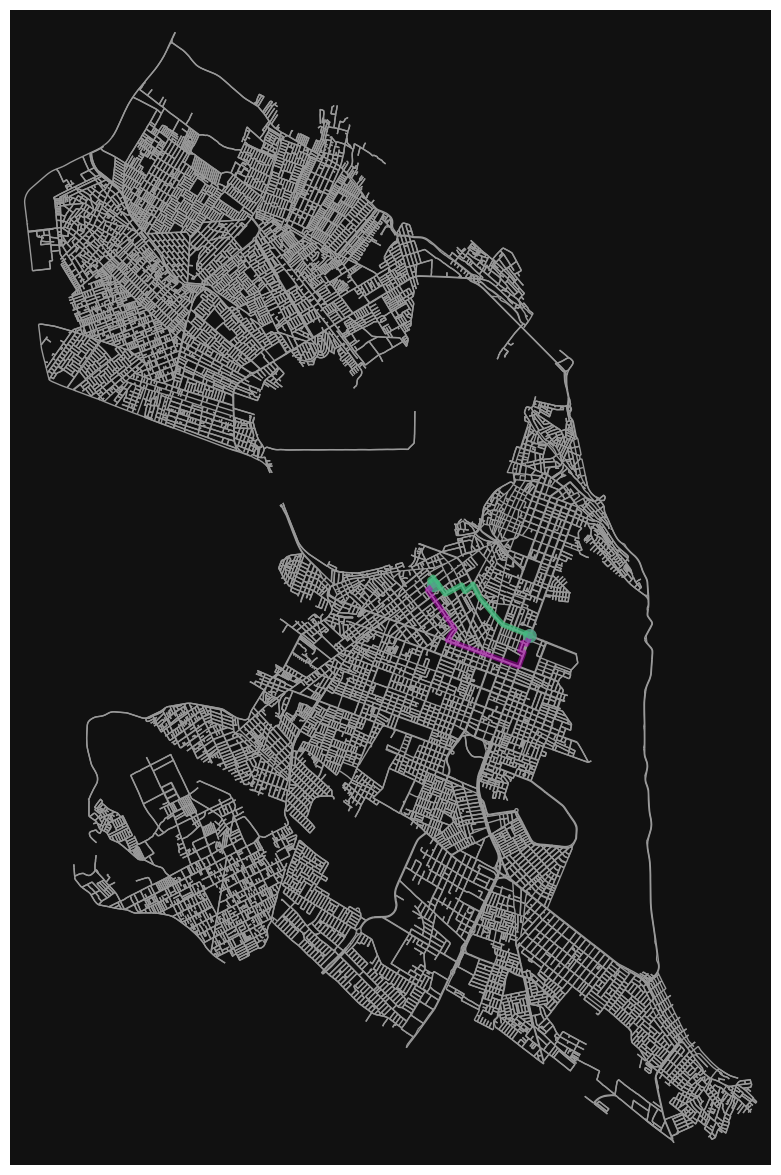

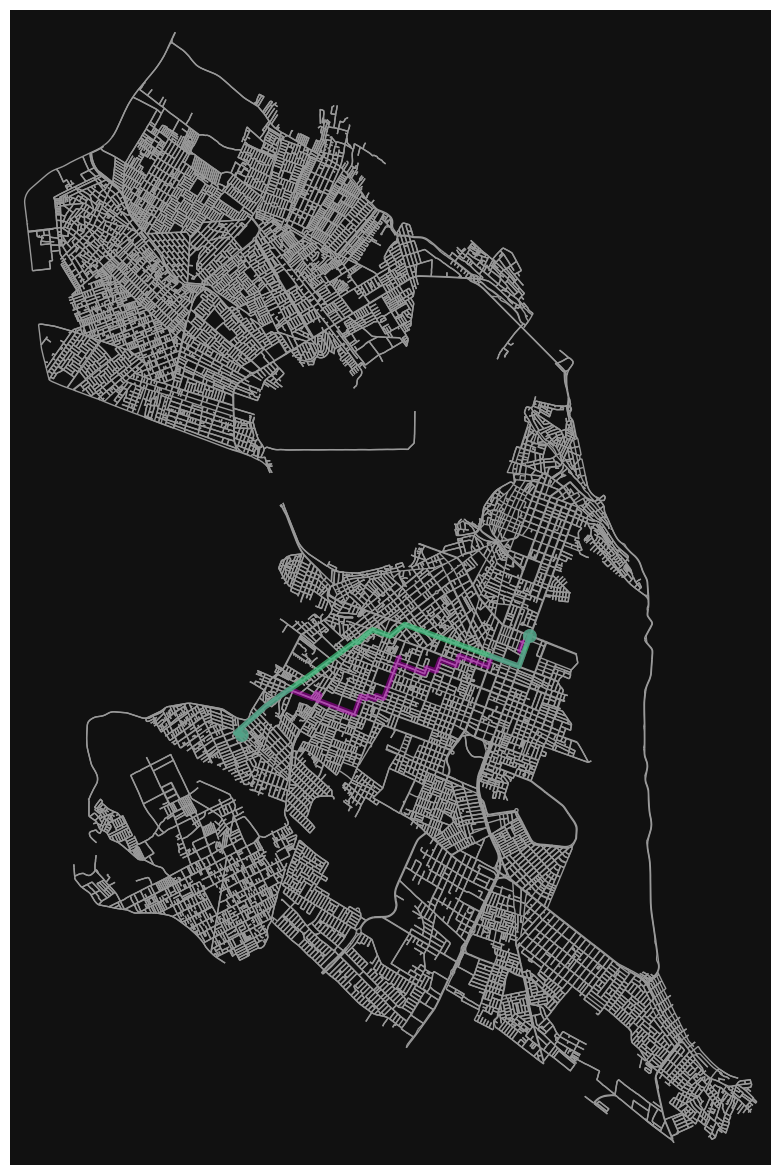

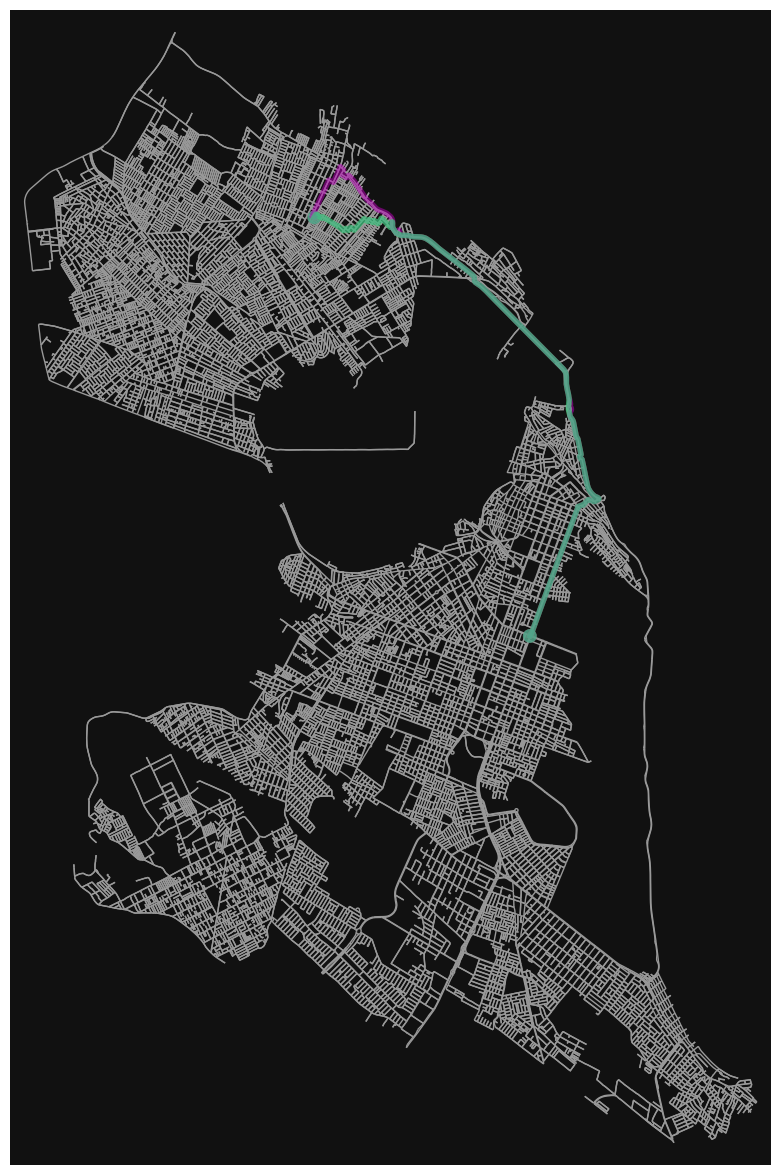

In [12]:
# Mapa Walfredo-Alecrim
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[paths_OSMnx[0], paths_Djk[0], paths_Djk_MH[0]], route_colors=["m", "y", "c"], route_linewidth=6, node_size=0, figsize=(15, 15)
)

# Mapa Walfredo-Camarão
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[paths_OSMnx[1], paths_Djk[1], paths_Djk_MH[1]], route_colors=["m", "y", "c"], route_linewidth=6, node_size=0, figsize=(15, 15)
)

# Mapa Walfredo-Pajuçara
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[paths_OSMnx[2], paths_Djk[2], paths_Djk_MH[2]], route_colors=["m", "y", "c"], route_linewidth=6, node_size=0, figsize=(15, 15)
)
